In [1]:
import sys 
sys.path.append('..')
import pandas as pd
from datetime import timedelta 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from ngboost.scores import LogScore
from ngboost.distns import LogNormal
from forecast_swiss import remove_zeros 
from ngboost.learners import default_tree_learner
from epigraphhub.models.plots import plot_val_ngb
from epigraphhub.analysis.clustering import compute_clusters
from epigraphhub.models.ngboost_models import train_eval_ngb, compute_metrics
from sklearn.metrics import (mean_absolute_error as mae, mean_squared_error as mse, mean_squared_log_error as msle,
                             mean_absolute_percentage_error as mape)

In [2]:
def get_clusters_swiss_article(t=0.3, end_date=None):
    """
    This function it was create to allow the reproduction of the results of the article.
    Params to get the list of clusters computed by the compute_cluster function.
    :params t: float. Thereshold used in the clusterization.
    :param end_date: string. Indicates the last day used to compute the cluster
    :returns: Array with the clusters computed.
    """
    df = pd.read_csv(
        f"data_article/data_to_get_clusters.csv"
    )

    df.set_index("datum", inplace=True)
    df.index = pd.to_datetime(df.index)

    if end_date != None:
        df = df.loc[:end_date]

    clusters = compute_clusters(
        df,
        ["georegion", "entries"],
        t=t,
        drop_georegions=["CH", "FL", "CHFL"],
        plot=True,
        smooth=True,
    )[1]

    return clusters

params_model = {
    "Base": default_tree_learner,
    "Dist": LogNormal,
    "Score": LogScore,
    "natural_gradient": True,
    "verbose": False,
    "col_sample": 0.9,
    "n_estimators": 100,
    "learning_rate": 0.05,
}

def train_eval_article(
    target_curve_name,
    canton,
    ini_date="2020-03-01",
    end_train_date=None,
    end_date=None,
    ratio=0.75,
    ratio_val=0.15,
    early_stop=5,
    parameters_model=params_model,
    predict_n=14,
    look_back=14,
):

    """
    This function it was create to allow the reproduction of the results of the article.
    Function to train and evaluate the model for one georegion.

    Important:
    * By default the function is using the clustering cantons and the data since 2020
    * For the predictor hospCapacity is used as predictor the column ICU_Covid19Patients

    :params canton: canton of interest
    :params ini_date: string. Determines the beggining of the train dataset
    :params end_train_date: string. Determines the beggining of end of train dataset. If end_train_date
                           is not None, then ratio isn't used.
    :params end_date: string. Determines the end of the dataset used in validation.
    :params ratio: float. Determines which percentage of the data will be used to train the model
    :params parameters_model: dict with the params that will be used in the ngboost
                             regressor model.
    :params predict_n: int. Number of days that will be predicted.
    :params look_back: int. Number of the last days that will be used to forecast the next days.

    returns: Dataframe.
    """

    target_name = f"{target_curve_name}_{canton}"

    df = pd.read_csv(f"data_article/data_{canton}.csv")

    df.set_index("datum", inplace=True)

    df.index = pd.to_datetime(df.index)

    df = df.fillna(0)

    df[target_name] = remove_zeros(df[target_name].values)

    if any(df[target_name] > 1):

        df_pred = train_eval_ngb(
            target_name,
            df,
            ini_date=ini_date,
            end_train_date=end_train_date,
            end_date=end_date,
            ratio=ratio,
            ratio_val=ratio_val,
            early_stop=early_stop,
            predict_n=predict_n,
            look_back=look_back,
            kwargs=parameters_model,
        )

        df_pred["canton"] = [target_name[-2:]] * len(df_pred)

    else:
        df_pred = pd.DataFrame()
        df_pred["target"] = df[target_name]
        df_pred["date"] = 0
        df_pred["lower"] = 0
        df_pred["median"] = 0
        df_pred["upper"] = 0
        df_pred["canton"] = target_name[-2:]

    return df_pred



### Computing the clusters:

This is the clusters used to train the ngboost models. 

[array(['AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'GL', 'GR', 'LU', 'NW', 'OW',
        'SG', 'SH', 'SO', 'SZ', 'TG', 'UR', 'ZG', 'ZH'], dtype=object),
 array(['FR', 'GE', 'JU', 'NE', 'TI', 'VD', 'VS'], dtype=object)]

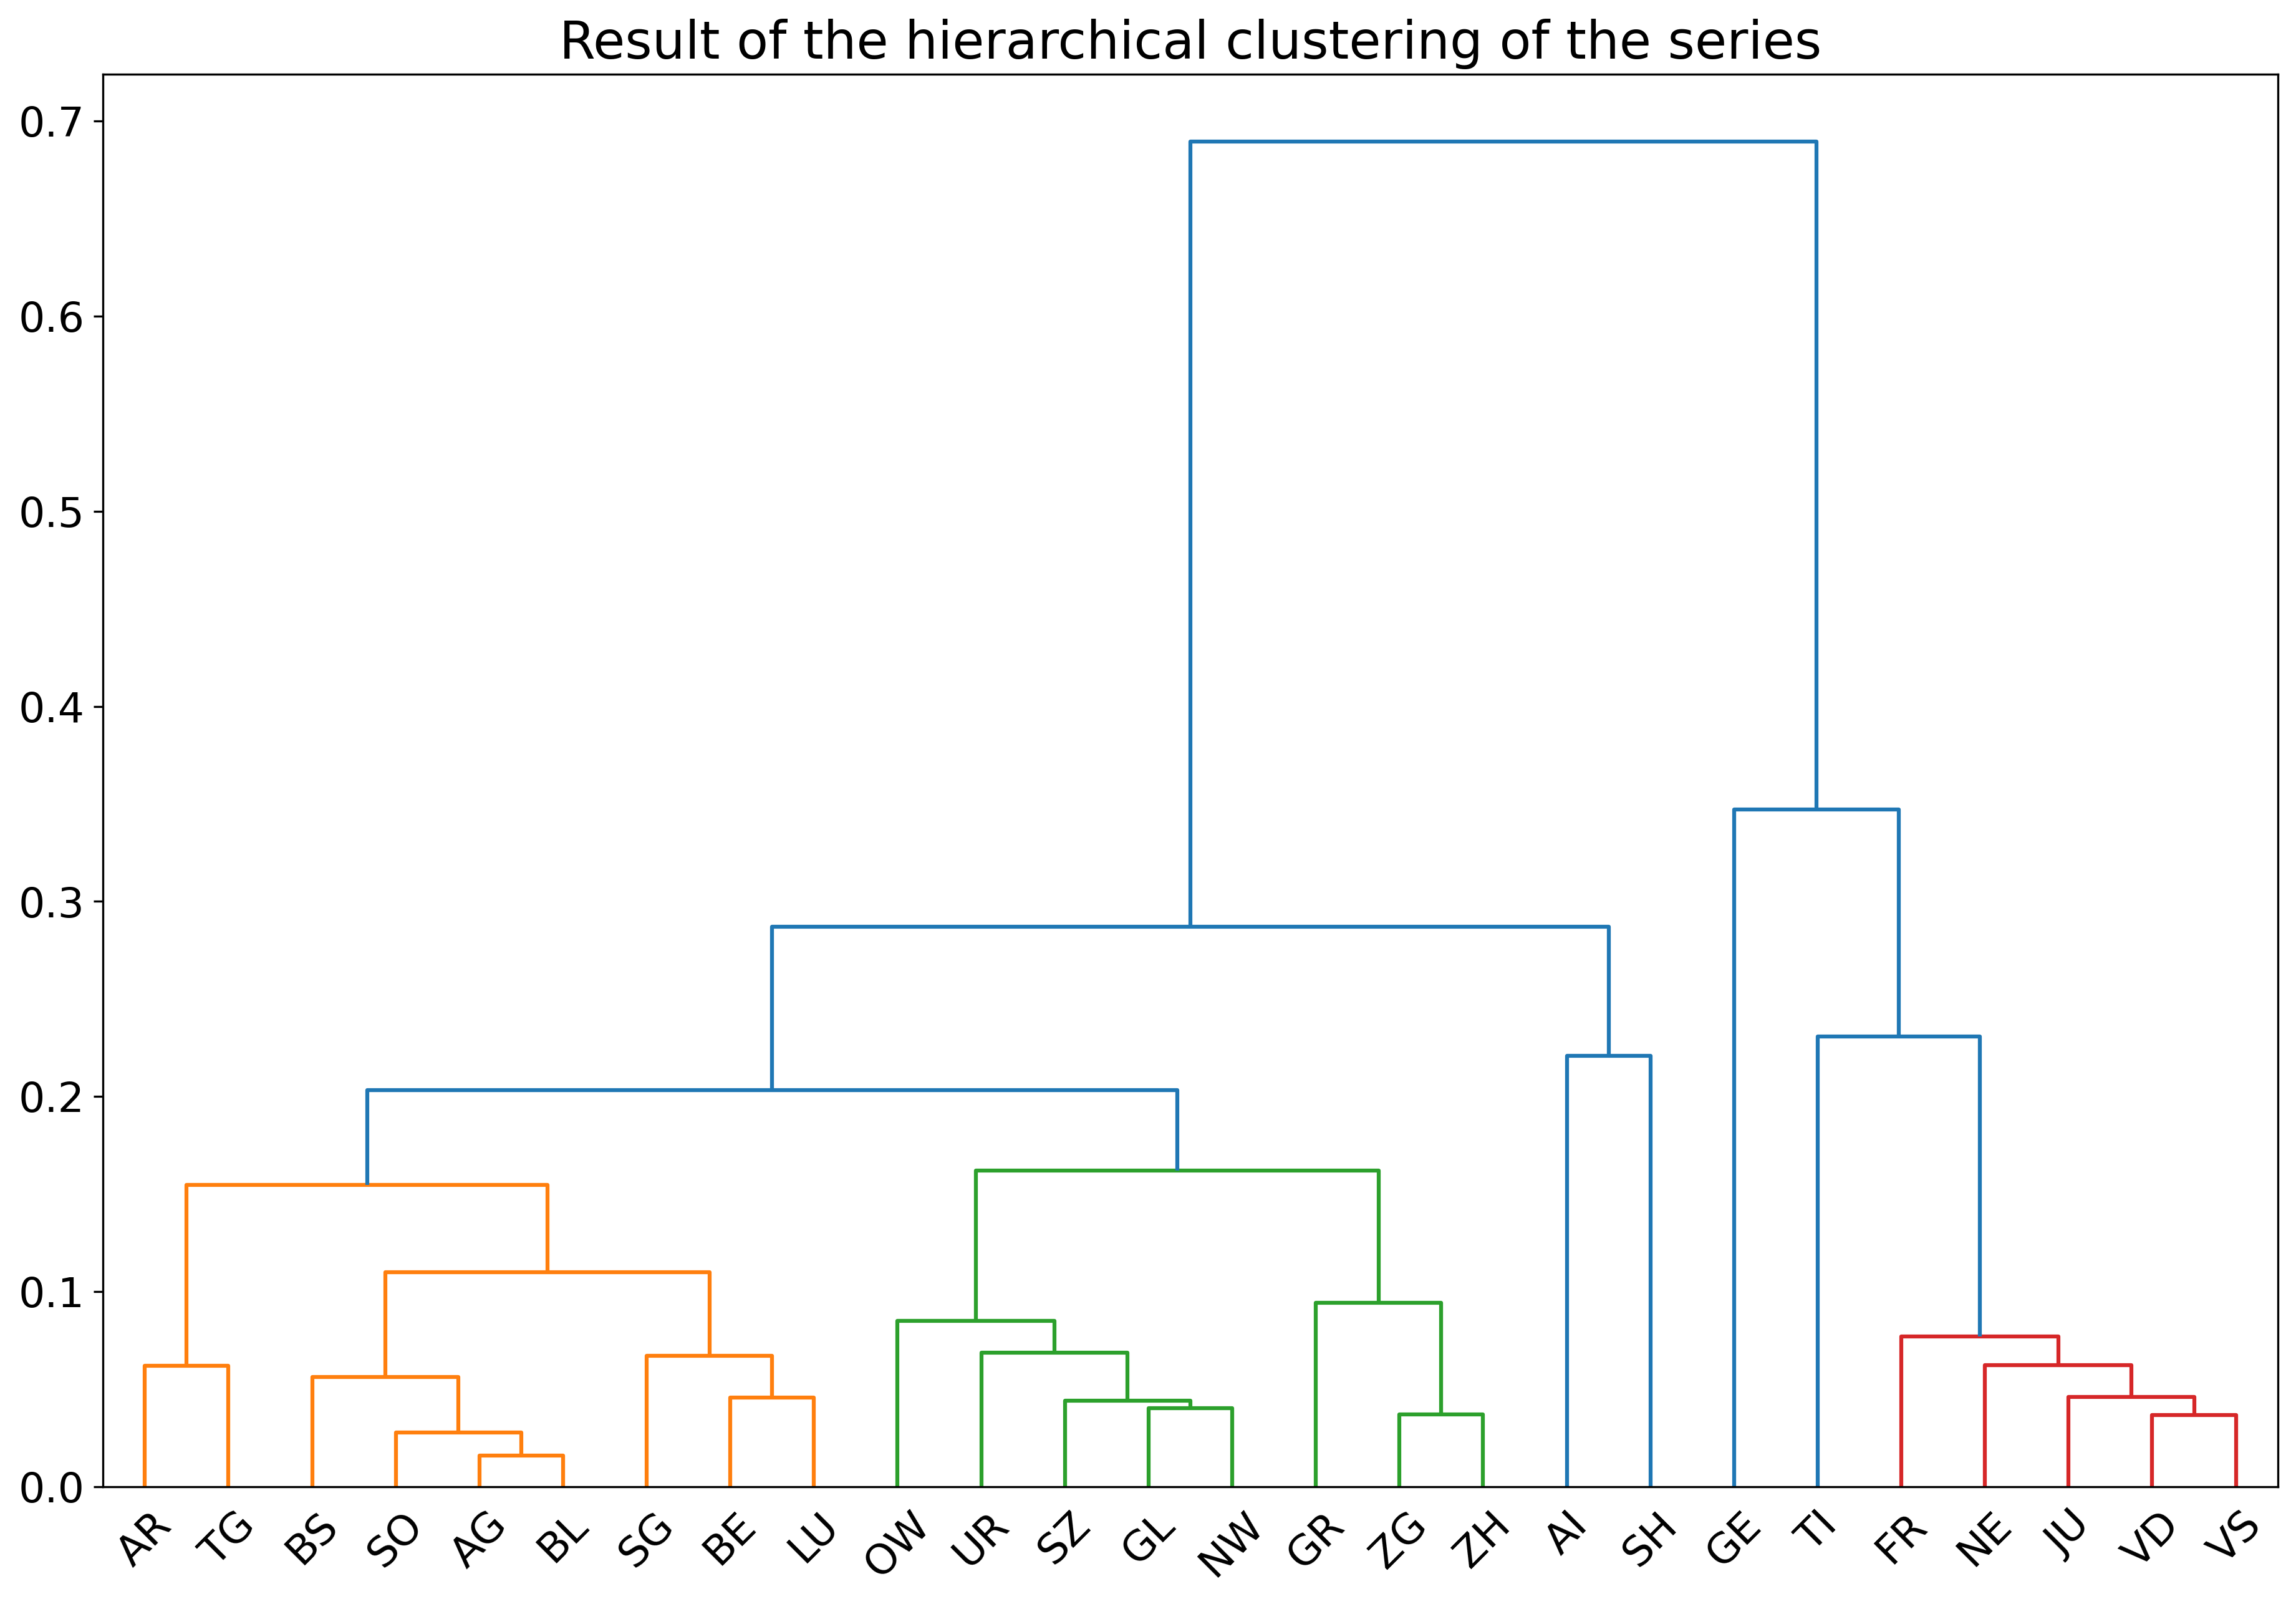

In [3]:
get_clusters_swiss_article(t=0.6, end_date = '2022-05-01')

## Train and eval (ratio = 0.75) 

### Hospitalizations

In [4]:
def train_eval(target_curve_name = 'hosp', predictors = ['foph_test_d', 'foph_cases_d', 'foph_hosp_d'], ini_date = '2020-05-01', ratio = 0.8,  early_stop = 10, end_date = '2022-04-30',  canton = 'GE'):
    
    df_eval = train_eval_article(target_curve_name, canton,ini_date = ini_date, end_date = end_date)
    
    dict_name = {'hosp': 'New hospitalizations',
                'total_hosp': 'Total Hospitalizations', 
                'icu_patients': 'Total ICU patients'}
    
    plot_val_ngb(df_eval, title = f'{dict_name[target_curve_name]} in {canton}', path = 'plots', name = f'val_{target_curve_name}_{canton}', save = True)

    df_m = compute_metrics(df_eval)
    
    df_m.to_csv(f'metrics/val_{target_curve_name}_{canton}.csv')
    
    return df_eval, df_m

#### Geneva

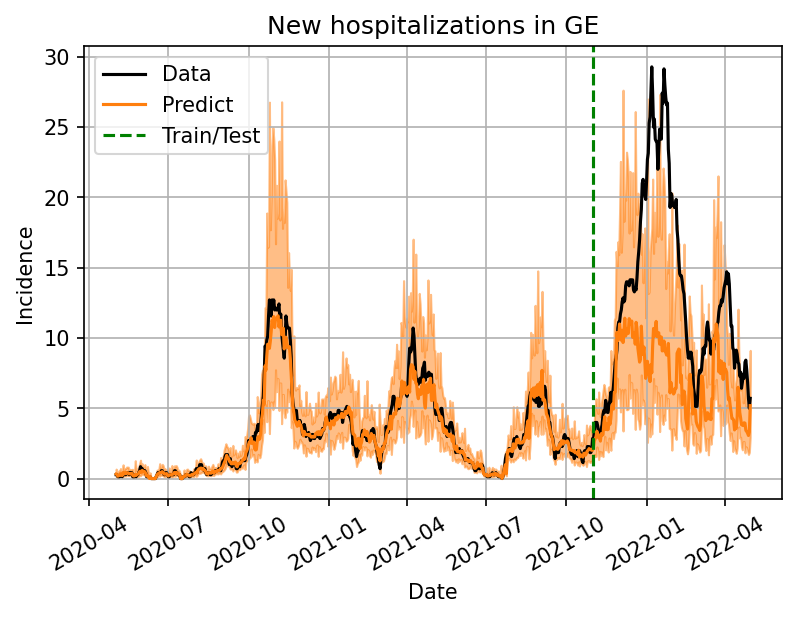

CPU times: user 1min 10s, sys: 414 ms, total: 1min 10s
Wall time: 1min 10s


,target,lower,median,upper,train_size,canton
date,,,,,,
2020-05-02,0.285714,0.159508,0.330032,0.682857,547,GE
2020-05-03,0.285714,0.188547,0.291622,0.451047,547,GE
2020-05-04,0.142857,0.081856,0.178292,0.388338,547,GE
2020-05-05,0.142857,0.091800,0.226675,0.559711,547,GE
2020-05-06,0.142857,0.096275,0.225577,0.528540,547,GE


In [5]:
%%time
df_eval_ge, df_m_ge = train_eval(canton = 'GE')

df_eval_ge.head()

#### Berna

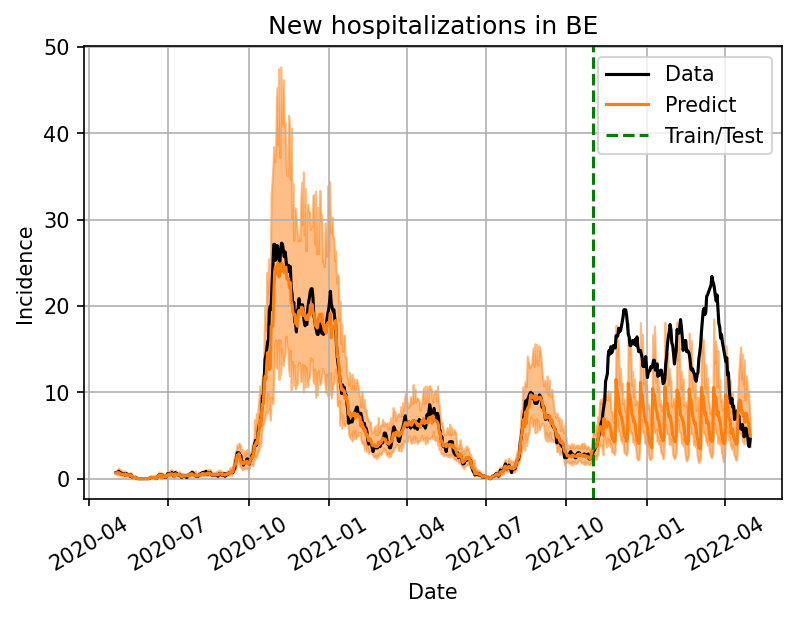

,target,lower,median,upper,train_size,canton
date,,,,,,
2020-05-02,0.714286,0.467417,0.661668,0.936647,547,BE
2020-05-03,0.714286,0.499924,0.702553,0.987311,547,BE
2020-05-04,0.714286,0.412695,0.672602,1.096193,547,BE
2020-05-05,0.857143,0.409314,0.708702,1.227074,547,BE
2020-05-06,0.714286,0.400676,0.612877,0.937460,547,BE


In [6]:
df_eval_be, df_m_be = train_eval(canton = 'BE')
df_eval_be.head()

In [7]:
df_m_be.head(6)

,in_sample,out_sample
metrics,,
explained_variance_score,0.983477,0.004439
mean_absolute_error,0.446592,7.292315
mean_squared_error,0.841582,71.325365
root_mean_squared_error,0.917378,8.445435
mean_squared_log_error,0.005653,0.567490
mean_absolute_percentage_error,0.099416,0.491890


#### Zurich

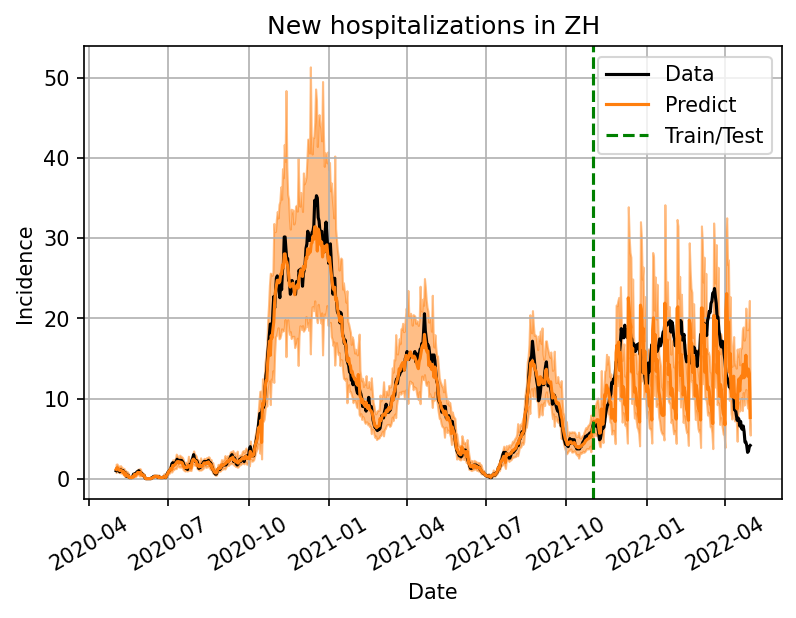

,target,lower,median,upper,train_size,canton
date,,,,,,
2020-05-02,1.000000,0.761235,1.171871,1.804018,547,ZH
2020-05-03,1.285714,1.023912,1.372911,1.840864,547,ZH
2020-05-04,1.142857,0.921625,1.237045,1.660414,547,ZH
2020-05-05,1.142857,0.809392,1.125640,1.565454,547,ZH
2020-05-06,0.857143,0.746526,1.026746,1.412152,547,ZH


In [8]:
df_eval_zh, df_m_zh = train_eval(canton = 'ZH')

df_eval_zh.head()

In [9]:
df_m_zh.head(6)

,in_sample,out_sample
metrics,,
explained_variance_score,0.991852,-0.266981
mean_absolute_error,0.481322,4.875580
mean_squared_error,0.674430,34.292572
root_mean_squared_error,0.821237,5.855986
mean_squared_log_error,0.005215,0.200680
mean_absolute_percentage_error,0.080120,0.393235
